# 🩺 **MAGFLOW**

> Análisis comparativo de los estudios de resonancia de flujo realizados a 20 pacientes con implante de vávlula áortica transcatéter (TAVI).

## **⚙️ Configuración**

---

Importación e inicialización de las librerías y dependencias necesarias.

In [2]:
# Standard library imports
from pathlib import Path

import matplotlib.pyplot as plt

# Third-party imports
import numpy as np
import pyvista as pv
from matplotlib import cm
from tqdm.notebook import tqdm

# Local imports
import magflow.utils.visualization as viz

%matplotlib inline
pv.set_jupyter_backend("static")
pv.global_theme.allow_empty_mesh = True

## **🏗️ Carga de datos**

---

Este módulo se encarga de la carga e inicialización de todos los conjuntos de datos necesarios para el análisis del flujo aórtico.

### **Campo de velocidades**

Se importan los datos de velocidad del flujo sanguíneo almacenados en formato VTK estructurado (`*.vts`), obtenidos mediante resonancia magnética de flujo 4D (4D Flow MRI). Adicionalmente, se carga la geometría aórtica tridimensional previamente segmentada en *3D Slicer*.

Todos los instantes temporales del ciclo cardíaco se almacenan en un diccionario indexado para facilitar el acceso y procesamiento. El **timestep 85** se utiliza como referencia por defecto, ya que corresponde al pico sistólico donde se alcanza la máxima velocidad del flujo y, por tanto, ofrece el mayor contraste para la visualización.

In [3]:
# Load velocity field data for all available timesteps
data_dir = Path("../../assets")

# List available timesteps using pathlib
available_files = [f.name for f in data_dir.iterdir() if f.name.startswith("data.vts.")]
available_timesteps = [int(f.split(".")[-1]) for f in available_files]
available_timesteps.sort()

# Display available timesteps as markdown
print(f"Available Timesteps: {available_timesteps}")

# Load all timesteps at once
timestep_data = {}
for ts in available_timesteps:
    filename = f"data.vts.{ts}"
    filepath = data_dir / filename
    if filepath.exists():
        timestep_data[ts] = pv.read(str(filepath), force_ext=".vts")
    else:
        print(f"Skipping timestep {ts}. File not found")

Available Timesteps: [0, 28, 57, 85, 113, 141, 170, 198, 226, 254, 283, 311, 339, 368, 396, 424, 452, 481, 509, 537, 566, 594, 622, 650]


### **Geometría aórtica**

Se carga el modelo geométrico 3D de la aorta obtenido mediante segmentación manual de imágenes de resonancia magnética utilizando *3D Slicer*. Esta geometría constituye el dominio anatómico sobre el cual se analizará la dinámica del flujo sanguíneo.

In [4]:
# Load the biomodel data
biomodel_path = Path("../../assets/biomodel.vtk")
biomodel_data = pv.read(str(biomodel_path))

# Apply rotations
biomodel_data.rotate_y(-90, inplace=True)
biomodel_data.rotate_z(-90, inplace=True)

# Apply translation
biomodel_data.translate([0, 300, 0], inplace=True)

# Flip the z-coordinates
points = np.array(biomodel_data.points)
points[:, 2] = -points[:, 2]
biomodel_data.points = points

### Línea central aórtica

Se importa la línea central (*centerline*) de la geometría aórtica calculada previamente mediante el *Vascular Modeling Toolkit* (VMTK). Esta línea central es fundamental para generar secciones transversales equiespaciadas a lo largo del eje longitudinal de la aorta, facilitando el análisis cuantitativo del flujo.

**Procesamiento requerido:**
- **Transformaciones geométricas**: Aplicación de rotaciones y traslaciones para conseguir la alineación espacial con la geometría aórtica y los datos de velocidad
- **Remuestreo**: Redistribución de puntos para obtener una resolución uniforme a lo largo de la trayectoria
- **Formato de salida**: Conversión a objeto PyVista PolyData para compatibilidad con el pipeline de análisis

La correcta alineación de la línea central es esencial para la generación posterior de planos ortogonales donde se calcularán los parámetros hemodinámicos.

In [5]:
# Load the centreline data from JSON file
centreline_path = Path("../../assets/centreline.json")

# Load and process centreline data
data = viz.load_centreline(centreline_path)
control_points = data["markups"][0]["controlPoints"]
positions = viz.extract_positions(control_points)

print(
    f"Loaded {len(positions)} valid control points from {len(control_points)} total points"
)

# Convert to numpy array and apply transformations
centreline_points = np.array(positions, dtype=np.float64)
centreline_points = viz.apply_transformations(centreline_points)

# Resample centreline with consistent parameter naming
NUM_CENTRELINE_POINTS = 20
centreline = viz.resample(centreline_points, num_points=NUM_CENTRELINE_POINTS)

# Validate resampled centreline
if len(centreline) != NUM_CENTRELINE_POINTS:
    print(f"Warning: Expected {NUM_CENTRELINE_POINTS} points, got {len(centreline)}")

# Create PyVista PolyData object
centreline_data = viz.create_polydata(centreline)

print(f"Centreline successfully processed with {len(centreline)} equidistant points")


Loaded 220 valid control points from 220 total points
Centreline successfully processed with 20 equidistant points


## **🖼️ Renderizado**

---

Visualización tridimensional del campo de velocidades mediante *PyVista*, mostrando la distribución espacial del flujo sanguíneo en secciones transversales ortogonales a la línea central aórtica.



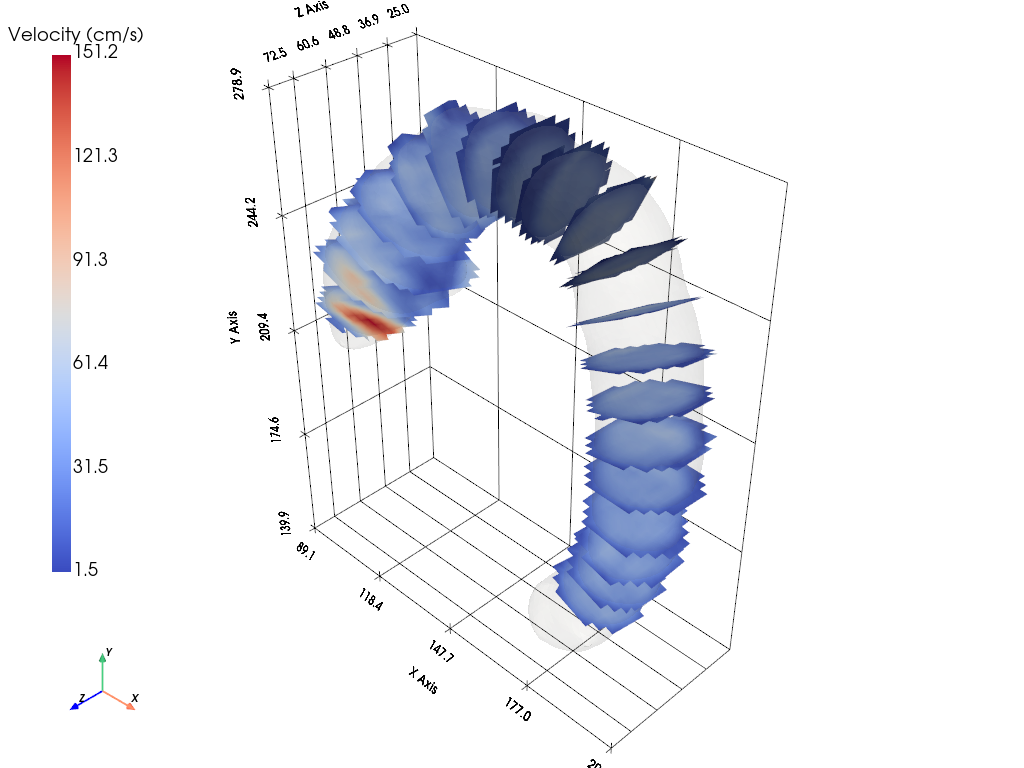

In [6]:
# Initialize the PyVista plotter for 3D visualization
plotter = pv.Plotter(notebook=True)
dataset = timestep_data[85]

# Extract aorta region from dataset
aorta = viz.extract_aorta(dataset, biomodel_data)
cross_sections = viz.ortoplanes(centreline, aorta, radius=25)

# Add biomodel as a wireframe to provide anatomical context
plotter.add_mesh(
    biomodel_data,
    color="white",
    opacity=0.1,
    label="Biomodel",
    show_edges=False,
)

# Add each cross-section with a different color
colors = cm.viridis(np.linspace(0, 1, len(cross_sections)))
for i, cross_section in enumerate(cross_sections):
    if cross_section.n_points > 0:  # Only add non-empty cross-sections
        plotter.add_mesh(
            cross_section,
            scalars="VelocityMagnitude",
            cmap="coolwarm",
            color=colors[i, :3],
            show_edges=False,
            scalar_bar_args={
                "title": "Velocity (cm/s)",
                "position_x": 0.05,
                "position_y": 0.25,
                "width": 0.05,
                "height": 0.7,
                "n_labels": 6,
                "fmt": "%.1f",
                "vertical": "True",
            },
        )

# Configure camera and grid for optimal viewing
plotter.isometric_view()
plotter.camera.up = [0, 1, 0]  # Set Y as the up direction
plotter.show_grid(font_size=10)
plotter.add_axes()

# Render the scene
plotter.show()

## 📊 **Análisis**

---

Los siguientes indicadores biomecánicos serán evaluados a lo largo del ciclo cardíaco:

- **Flujo volumétrico** (*Q*) - Volumen de sangre por unidad de tiempo [`m³/s`]
- **Velocidad máxima** (*v*<sub>max</sub>) - Velocidad pico en las secciones aórticas [`m/s`]
- **TAWSS** (*Time-Averaged Wall Shear Stress*) - Esfuerzo cortante promedio [`Pa`]
- **OSI** (*Oscillatory Shear Index*) - Índice de oscilación del esfuerzo cortante [`adimensional`]
- **Pérdida de carga** - Disipación de energía en el flujo [`Pa`]
- **Gradientes de presión** - Variación espacial de la presión [`Pa/m`]
- **Vorticidad** - Medida de la rotación local del fluido [`s⁻¹`]
- **Helicidad** - Correlación entre velocidad y vorticidad [`m²/s²`]

### **Flujo volumétrico**

El flujo volumétrico cuantifica el volumen de sangre por unidad de tiempo que atraviesa una sección transversal aórtica. Este parámetro hemodinámico fundamental se calcula a partir de la integración del campo de velocidades sobre la superficie de la sección:

$$
Q = \int_A \vec{v} \cdot \hat{n} \, dA
$$

Donde:
- *Q* = flujo volumétrico [m³/s]
- $\vec{v}$ es el vector velocidad en cada punto
- $\hat{n}$ es el vector normal unitario a la superficie
- $A$ es el área de la sección transversal

**Protocolo de análisis:**

1. **Definición de secciones**: Se generan múltiples planos transversales ortogonales, distribuidos uniformemente a lo largo de la línea central aórtica
2. **Análisis temporal**: Los cálculos se realizan para cada instante temporal del ciclo cardíaco completo
3. **Promediado espacial**: Se calcula el valor medio de todas las secciones para facilitar la comparación entre pacientes

Processing timesteps:   0%|          | 0/24 [00:00<?, ?it/s]

Calculating flow rates:   0%|          | 0/24 [00:00<?, ?it/s]

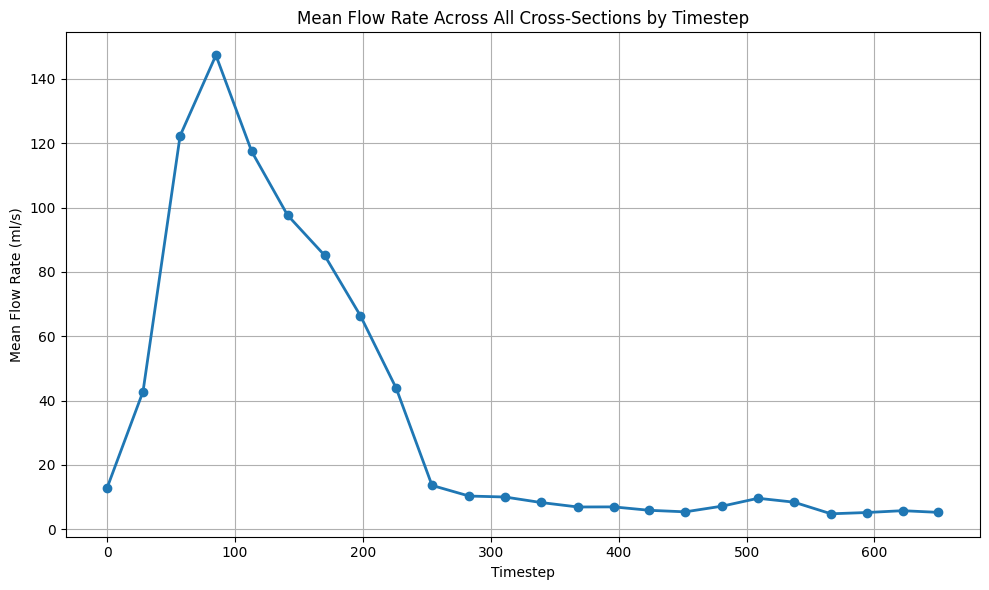

In [7]:
# Process each timestep
cross_sections = {}
timesteps = sorted(timestep_data.keys())
for ts in tqdm(timesteps, desc="Processing timesteps"):
    dataset = timestep_data[ts]
    aorta = viz.extract_aorta(dataset, biomodel_data)
    cross_sections[ts] = viz.ortoplanes(centreline, aorta, radius=20)
mean_flow_rates = {}

for ts in tqdm(timesteps, desc="Calculating flow rates"):
    flow_rates = []

    for cross_section in cross_sections[ts]:
        if cross_section.n_points == 0:
            continue

        # Convert velocity first
        velocity_mm = cross_section["Velocity"] * 10

        # Compute normals and ensure they match the velocity array size
        if "Normals" not in cross_section.point_data:
            cross_section.compute_normals(point_normals=True, inplace=True)

        # Get normals and ensure they match velocity array dimensions
        normals = cross_section["Normals"]

        # Handle dimension mismatch by taking minimum length
        min_length = min(len(velocity_mm), len(normals))
        velocity_mm = velocity_mm[:min_length]
        normals = normals[:min_length]

        # Calculate normal component
        normal_vel = np.sum(velocity_mm * normals, axis=1)

        # Add normal velocity as point data and integrate
        cross_section["NormalVelocity"] = normal_vel

        # Calculate total flow using area-weighted integration
        total_area = cross_section.area
        flow_rate = np.abs(np.mean(normal_vel) * total_area) / 1000

        flow_rates.append(flow_rate)

    mean_flow_rates[ts] = np.mean(flow_rates) if flow_rates else 0

# Create figure
plt.figure(figsize=(10, 6))
plt.plot(
    timesteps,
    [mean_flow_rates[ts] for ts in timesteps],
    "o-",
    linewidth=2,
)
plt.title("Mean Flow Rate Across All Cross-Sections by Timestep")
plt.xlabel("Timestep")
plt.ylabel("Mean Flow Rate (ml/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

### **Velocidad máxima**

La velocidad máxima (*v*<sub>max</sub>) representa el valor pico de velocidad del flujo sanguíneo registrado en cada sección transversal aórtica durante el ciclo cardíaco.

**Definición matemática:**

$$
v_{max} = \max(\vec{v} \cdot \hat{n})
$$

Donde:
- *v*<sub>max</sub> = velocidad máxima en la sección [m/s]
- $\vec{v}$ = vector velocidad en cada punto [m/s]
- $\hat{n}$ = vector normal unitario a la sección

**Metodología de cálculo:**

1. **Extracción de velocidades**: Se obtienen las componentes normales de velocidad en cada punto de las secciones transversales
2. **Identificación del máximo**: Se determina el valor pico de velocidad para cada sección y timestep
3. **Análisis temporal**: Se evalúa la evolución de la velocidad máxima a lo largo del ciclo cardíaco

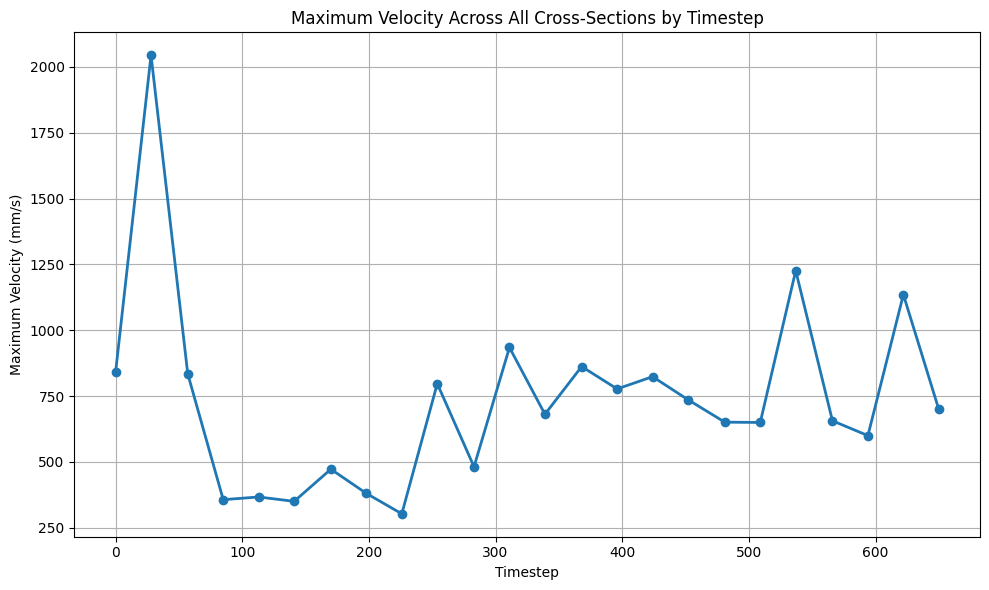

In [8]:
# Create figure
plt.figure(figsize=(10, 6))

max_velocities = {}
# Process each timestep
for ts in timesteps:
    velocities = []
    # Add each cross-section with a different color
    for cross_section in cross_sections[ts]:
        # Extract velocity vectors at each point in the cross-section
        velocity_vectors = cross_section["Velocity"] * 10  # Convert from cm/s to mm/s

        # Get normals of the cross-section (ensure point normals)
        cross_section.compute_normals(
            cell_normals=False, point_normals=True, inplace=True
        )
        section_normals = cross_section["Normals"]

        # Ensure both arrays have the same length by taking the minimum
        min_length = min(len(velocity_vectors), len(section_normals))
        velocity_vectors_trimmed = velocity_vectors[:min_length]
        section_normals_trimmed = section_normals[:min_length]

        # Calculate dot product of velocity and normal at each point
        normal_velocities = np.sum(
            velocity_vectors_trimmed * section_normals_trimmed, axis=1
        )
        velocities.extend(normal_velocities)

    # Store the mean flow rate for this timestep (if there are valid sections)
    if velocities:
        max_velocities[ts] = np.max(velocities)
    else:
        max_velocities[ts] = 0

plt.plot(
    timesteps,
    [max_velocities[ts] for ts in timesteps],
    "o-",
    linewidth=2,
)

plt.title("Maximum Velocity Across All Cross-Sections by Timestep")  # Updated title
plt.xlabel("Timestep")
plt.ylabel("Maximum Velocity (mm/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

### **Esfuerzo parietal (WSS)**

El esfuerzo cortante parietal (*Wall Shear Stress*, WSS) representa la tensión tangencial que ejerce el flujo sanguíneo sobre la pared arterial. Este parámetro biomecánico es fundamental para evaluar el riesgo de aterosclerosis y la integridad endotelial post-TAVI.

**Definición matemática:**

Para un flujo cerca de la pared arterial, el WSS se define como:

$$
\tau_w = \mu \left. \frac{\partial u}{\partial n} \right|_{pared}
$$

**Donde:**
- $\tau_w$ = esfuerzo cortante parietal [Pa]
- $\mu$ = viscosidad dinámica de la sangre (≈ 0.004 Pa·s)
- $\frac{\partial u}{\partial n}$ = gradiente de velocidad normal a la pared arterial [s⁻¹]

**Significado clínico:**

- **WSS bajo (< 0.4 Pa)**: Asociado con activación endotelial, inflamación y aterogénesis
- **WSS fisiológico (0.4-1.5 Pa)**: Rango normal que mantiene la función endotelial
- **WSS elevado (> 1.5 Pa)**: Puede indicar estenosis o turbulencia local

**Metodología de cálculo:**

1. **Identificación de la superficie**: Se utiliza la geometría aórtica segmentada como superficie de pared
2. **Cálculo de gradientes**: Se determinan los gradientes de velocidad perpendiculares a la superficie
3. **Análisis temporal**: Se evalúa la evolución del WSS durante todo el ciclo cardíaco

Este análisis permite identificar regiones de riesgo aterosclerótico y evaluar el impacto hemodinámico del implante valvular transcatéter.

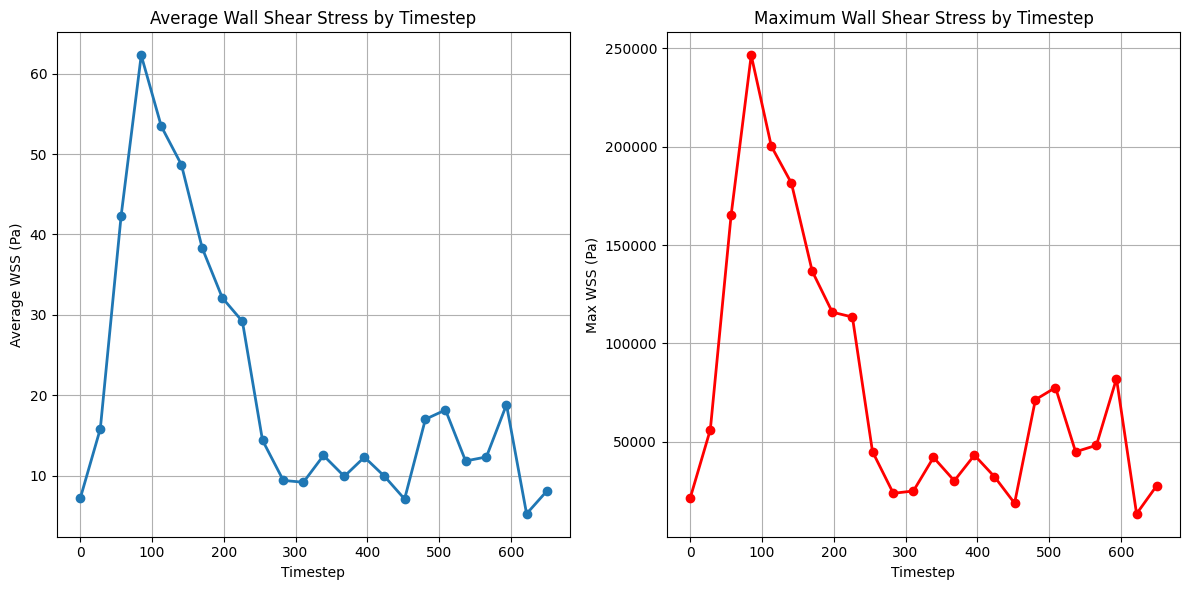

In [9]:
# Parameters
mu = 0.004  # Blood viscosity in Pa·s (typical value)

# Extract the wall points from biomodel
biomodel_data.compute_normals(cell_normals=False, point_normals=True, inplace=True)
wall_points = np.array(biomodel_data.points)
wall_normals = np.array(biomodel_data["Normals"])

# Initialize result dictionaries
wss_values = {}
max_wss_values = {}
avg_wss_values = {}

for ts in timesteps:
    # Get current dataset
    dataset = timestep_data[ts]
    aorta = viz.extract_aorta(dataset, biomodel_data)

    # Calculate WSS for this timestep
    wss = viz.calculate_wss_timestep(wall_points, wall_normals, aorta, mu)

    # Store results
    wss_values[ts] = wss
    max_wss_values[ts] = np.max(wss)
    avg_wss_values[ts] = np.mean(wss)

# Plot average and max WSS over time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(timesteps, [avg_wss_values[ts] for ts in timesteps], "o-", linewidth=2)
plt.title("Average Wall Shear Stress by Timestep")
plt.xlabel("Timestep")
plt.ylabel("Average WSS (Pa)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(
    timesteps, [max_wss_values[ts] for ts in timesteps], "o-", linewidth=2, color="red"
)
plt.title("Maximum Wall Shear Stress by Timestep")
plt.xlabel("Timestep")
plt.ylabel("Max WSS (Pa)")
plt.grid(True)

plt.tight_layout()
plt.show()

### **Índice de esfuerzo cortante oscilatorio (OSI)**

El Índice de Esfuerzo Cortante Oscilatorio (*Oscillatory Shear Index*, OSI) cuantifica la variabilidad direccional del esfuerzo cortante parietal durante el ciclo cardíaco. Este parámetro es fundamental para identificar regiones con riesgo elevado de aterogénesis y disfunción endotelial.

**Definición matemática:**

$$
OSI = \frac{1}{2} \left( 1 - \frac{\left| \int_0^T \vec{\tau_w} \, dt \right|}{\int_0^T \left| \vec{\tau_w} \right| \, dt} \right)
$$

**Donde:**
- *OSI* = índice de esfuerzo cortante oscilatorio [adimensional]
- $\vec{\tau_w}$ = vector de esfuerzo cortante parietal [Pa]
- *T* = período del ciclo cardíaco [s]

**Interpretación clínica:**

- **OSI ≈ 0**: Flujo unidireccional estable, condiciones hemodinámicas favorables
- **OSI ≈ 0.5**: Flujo altamente oscilatorio, riesgo aterogénico máximo
- **OSI > 0.2**: Umbral asociado con activación endotelial y formación de placas

**Significado biomecánico:**

El OSI evalúa la relación entre el esfuerzo cortante vectorial promedio y su magnitud promedio. Valores altos indican cambios frecuentes en la dirección del flujo, creando un ambiente proaterogénico que favorece la disfunción endotelial, la inflamación local y el desarrollo de aterosclerosis.

Este análisis es particularmente relevante en pacientes post-TAVI para evaluar las alteraciones hemodinámicas inducidas por el implante valvular y su potencial impacto en la progresión de la enfermedad cardiovascular.

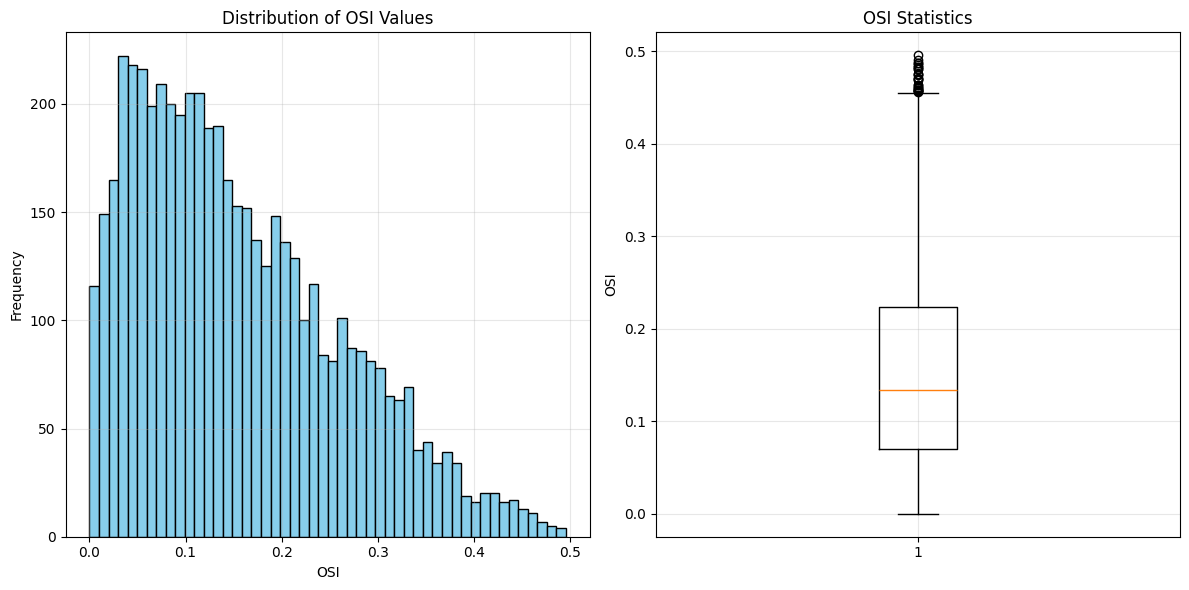

Mean OSI: 0.1555
Median OSI: 0.1337
Max OSI: 0.4959
Min non-zero OSI: 0.0019


In [10]:
# Calculate OSI for each wall point using external function
osi_values = viz.calculate_osi(timesteps, timestep_data, biomodel_data, mu)

# Add OSI values to biomodel for visualization
biomodel_data["OSI"] = osi_values

# Create a histogram of OSI values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(osi_values, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of OSI Values")
plt.xlabel("OSI")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(osi_values)
plt.title("OSI Statistics")
plt.ylabel("OSI")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print OSI statistics
print(f"Mean OSI: {np.mean(osi_values):.4f}")
print(f"Median OSI: {np.median(osi_values):.4f}")
print(f"Max OSI: {np.max(osi_values):.4f}")
print(f"Min non-zero OSI: {np.min(osi_values[osi_values > 0]):.4f}")

### **Pérdida de energía viscosa**

La pérdida de energía viscosa (*Viscous Energy Loss*, VEL) cuantifica la disipación de energía mecánica del flujo sanguíneo debido a las fuerzas viscosas. Este parámetro es fundamental para evaluar la eficiencia hemodinámica y detectar anomalías en el flujo post-TAVI.

**Definición matemática:**

Para un fluido newtoniano incompresible, la función de disipación viscosa se define mediante el tensor de deformación:

$$
\Phi = \mu \sum_{i,j} \left( \frac{\partial u_i}{\partial x_j} + \frac{\partial u_j}{\partial x_i} \right)^2 = 2\mu \sum_{i,j} S_{ij}^2
$$

**Donde:**
- $\Phi$ = función de disipación viscosa [W/m³]
- $\mu$ = viscosidad dinámica de la sangre (≈ 0.004 Pa·s)
- $u_i$ = componentes de velocidad [m/s]
- $x_j$ = coordenadas espaciales [m]
- $S_{ij}$ = tensor de deformación simétrico [s⁻¹]

**Pérdida total de energía:**

La pérdida total se obtiene integrando la función de disipación sobre todo el volumen aórtico:

$$
E_{loss} = \int_V \Phi \, dV \quad [W]
$$

**Significado clínico:**

La VEL proporciona información sobre:
- **Eficiencia energética** del flujo sanguíneo
- **Presencia de turbulencias** locales
- **Impacto hemodinámico** del implante TAVI
- **Pérdidas de carga** en el sistema cardiovascular

Este análisis permite evaluar la calidad hemodinámica post-intervención y detectar regiones con disipación energética elevada que pueden comprometer la función cardiovascular.

Calculating viscous energy loss for all timesteps...
Viscous energy loss calculation completed for 24 timesteps
Viscous energy loss calculation completed for 24 timesteps


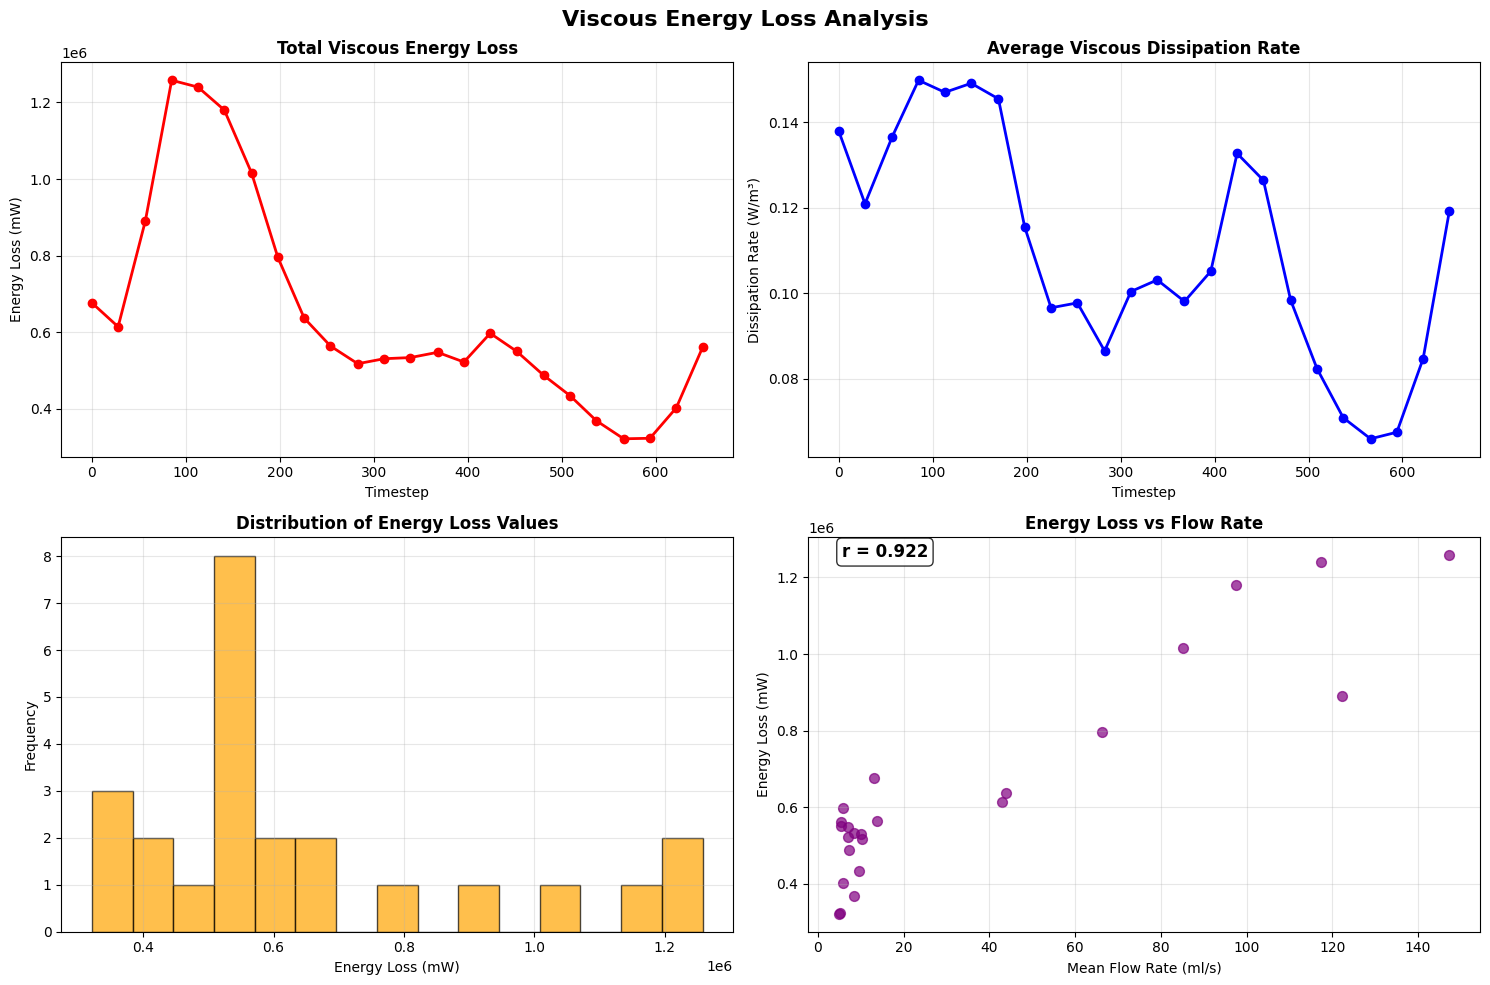


VISCOUS ENERGY LOSS SUMMARY
------------------------------
Peak energy loss: 1258021.83 mW
Mean energy loss: 648404.36 mW
Minimum energy loss: 321125.86 mW
Peak occurs at timestep: 85
Flow rate correlation: 0.922
Correlation strength: strong
Total energy per cycle: 622.6430 J
Energy efficiency ratio: 0.255


In [11]:
# Parameters for viscous energy loss calculation
mu = 0.004  # Blood viscosity in Pa·s (typical value)

# Calculate viscous energy loss for all timesteps using refactored functions
viscous_energy_loss = {}
total_dissipation = {}
avg_dissipation_rate = {}

print("Calculating viscous energy loss for all timesteps...")

# Process each timestep
for ts in timesteps:
    dataset = timestep_data[ts]
    aorta = viz.extract_aorta(dataset, biomodel_data)

    # Calculate energy loss for this timestep
    energy_loss, total_diss, avg_diss = viz.calculate_viscous_energy_loss_timestep(
        aorta, mu
    )

    # Store results
    viscous_energy_loss[ts] = energy_loss
    total_dissipation[ts] = total_diss
    avg_dissipation_rate[ts] = avg_diss

print(f"Viscous energy loss calculation completed for {len(timesteps)} timesteps")

# Create comprehensive visualization
fig, correlation_coef = viz.create_energy_loss_plots(
    timesteps, viscous_energy_loss, avg_dissipation_rate, mean_flow_rates
)
plt.show()

# Convert to mW for display
energy_loss_mw = [viscous_energy_loss[ts] * 1000 for ts in timesteps]

print("\nVISCOUS ENERGY LOSS SUMMARY")
print("-" * 30)

# Basic statistics
peak_energy = max(energy_loss_mw)
mean_energy = np.mean(energy_loss_mw)
min_energy = min(energy_loss_mw)
peak_timestep = max(viscous_energy_loss, key=viscous_energy_loss.get)

print(f"Peak energy loss: {peak_energy:.2f} mW")
print(f"Mean energy loss: {mean_energy:.2f} mW")
print(f"Minimum energy loss: {min_energy:.2f} mW")
print(f"Peak occurs at timestep: {peak_timestep}")

# Correlation analysis
print(f"Flow rate correlation: {correlation_coef:.3f}")
if abs(correlation_coef) > 0.7:
    strength = "strong"
elif abs(correlation_coef) > 0.3:
    strength = "moderate"
else:
    strength = "weak"
print(f"Correlation strength: {strength}")

# Cardiac cycle analysis
cycle_duration = 1.0  # seconds (typical cardiac cycle)
total_cycle_energy = np.trapezoid(
    list(viscous_energy_loss.values()), dx=cycle_duration / len(timesteps)
)

print(f"Total energy per cycle: {total_cycle_energy:.4f} J")
print(f"Energy efficiency ratio: {min_energy / peak_energy:.3f}")
